**классификатор текстов LSTM**

с сортировкой по длинне строк при формировании батчей

Евгений Борисов <esborisov@sevsu.ru>

https://habr.com/ru/company/dca/blog/274027/    
http://help.sentiment140.com/for-students/   
http://study.mokoron.com  

## Библиотеки

In [1]:
import numpy as np
import numpy.random as rng

import pandas as pd
pd.options.display.max_colwidth = 200  
import re
# import gzip
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
# from torchviz import make_dot

In [3]:
tqdm.pandas()

In [4]:
def pp(d): return "{:,.0f}".format(d).replace(",", " ")
def ppr(d): print('записей:', pp(len(d)) )  

## Данные

In [5]:
ff = ['id', 'tdate', 'tmane', 'ttext', 'ttype', 'trep', 'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount','unk']

In [6]:
neg = pd.read_csv('../data/twit/negative.csv.gz',sep=';',header=None)
ppr(neg)
neg.columns = ff

записей: 111 923


In [7]:
pos = pd.read_csv('../data/twit/positive.csv.gz',sep=';')
ppr(pos)
pos.columns = ff

записей: 114 910


In [8]:
data = pd.concat([pos,neg],sort=False)[['id','ttext', 'ttype']]
ppr(data)

записей: 226 833


In [9]:
data.sample(10)

,id,ttext,ttype
9128,410288543463141376,"Копаться в этой лжи, созданной эксплуататорами для одурманивания трудящихся для меня мерзко. Поэтому я просто молчу :-/",-1
82505,419840941248503808,Онам ман хакимда ичи кора деган фикрга боришларини хохламийман((((((,-1
55564,410083346350604288,"RT @danil_stas: Серый, ты ли это? :D http://t.co/SKgppjbJPk",1
70008,417647583730085888,RT @SychyovaSasha: новогоднего настроения вообще нет(,-1
23079,409489478492127232,быть четким?Протри зеркало!) http://t.co/S9O1dCx3Ta,1
35322,409774428609056768,"И вообще, я слишком домашняя стала) сегодня только @ENadtochiy на пару часов вышла, ибо соскучилась за этой мартышкой",1
92326,410860670784389120,@MuT9u Спасибки) Спокойной ночи!) @xarymb @RomantiKa_85 @LjubovJung @gena_grandig @maslennikovaEle @XXimars @lechiy13 @tat881 @Pravodumru,1
102100,411099471489937408,"Вот представьте: у тебя играет Links 2, 3, 4, а они маршируют.\nНу глаз же радуется)",1
54428,415704313478905856,"@N_navsegda ты бы знала,что было вчера .. я из-за этого прдурока на треню не пошла!( ахах вот чё щас делать ахах(",-1
16110,409356745212190720,"Говорю с подругой по телефону. Я: - Пойду к окну... Она: - Пойди, какни :D",1


## очистка данных

In [10]:
data['ttext_clean'] = data['ttext']\
    .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
    .progress_apply(lambda t:[ re.sub(r'^http.*',' url ', w.strip() ) for w in t ] )\
    .progress_apply(lambda t:[ re.sub(r'[:;]-*[)D]',' happysmile ', w.strip() )for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'\)\)\)*',' happysmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'[:;]\*',' kisssmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r':\(',' sadsmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'\(\(\(*',' sadsmile ', w.strip() ) for w in t ])

100%|██████████| 226833/226833 [00:02<00:00, 113112.82it/s]


In [11]:
data['ttext_clean'] = [ ' '.join(s) for s in data['ttext_clean'] ]

In [12]:
data['ttext_clean'] = data['ttext_clean'].str.lower()\
    .progress_apply(lambda s: re.sub( r'\W', ' ', s))\
    .progress_apply(lambda s: re.sub( r'_', ' ', s))\
    .progress_apply(lambda s: re.sub( r'\b\d+\b', ' digit ', s))\
    .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
    .progress_apply(lambda t: [w for w in t if not re.match( r'\b.*\d+.*\b', w) ])

100%|██████████| 226833/226833 [00:02<00:00, 100811.46it/s]


In [13]:
data.sample(3)

,id,ttext,ttype,ttext_clean
38529,413780182919434242,"@_katyavasina_ кассирша в атб подумала, что мне нет 18 и без документов не хотела продавать энергетик(",-1,"[katyavasina, кассирша, в, атб, подумала, что, мне, нет, digit, и, без, документов, не, хотела, продавать, энергетик]"
54946,410078004803796993,Уроки познавательной геометрии у нас в парадной:) #япаркуюськакмудак @ Любимый 24-ый этаж http://t.co/d7BxGksRrL,1,"[уроки, познавательной, геометрии, у, нас, в, парадной, happysmile, япаркуюськакмудак, любимый, digit, ый, этаж, url]"
77258,419153419036004352,"Что то даже идти не могу,такое чувство как сейчас уподу:(((",-1,"[что, то, даже, идти, не, могу, такое, чувство, как, сейчас, уподу, sadsmile, sadsmile]"


In [14]:
ppr(data)
data = data[ data['ttext_clean'].str.len()>0 ].reset_index(drop=True) 
ppr(data)

записей: 226 833
записей: 226 833


In [15]:
data['label'] = data['ttype'].apply(lambda y:max(0,y))
data['text'] = data['ttext_clean'].apply(' '.join)

In [16]:
data[['text','label']].sample(3)

,text,label
214604,я скучаю по танцам хочу на баллет стретч модерн performance class чирлидинг и gcse безумно хочу на танцы,0
101424,что тебе привезти похер абсолютно ну сложный выбор игрушка статуэтка ожерелье пфф ни разу не сложный понял игрушка обожаю тебя happysmile,1
72458,любимой удачи на олимпиаде завтра kisssmile я в тебя верю digit,1


In [17]:
data[['text','label']].to_csv('data.tsv', index=False, sep='\t')

## строим датасет

In [18]:
from torchtext.data import Field
from torchtext.data import TabularDataset

In [19]:
def tokenizer(text): return text.split() 

field_text = Field( sequential=True, use_vocab=True, tokenize=tokenizer, pad_first=True, ) # batch_first=True)
field_label = Field( sequential=False, use_vocab=False, ) # is_target=True, batch_first=True, dtype=torch.long)

# загружаем датасет в формате Torch
ds = TabularDataset(
            path = './data.tsv',
            format = 'tsv', #'tsv' for tabs, 'csv' for commas
            fields = [
                ('text',field_text),
                ('label',field_label),
            ],
            skip_header=True,
    )

/usr/lib/python3.9/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/lib/python3.9/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/usr/lib/python3.9/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example

In [20]:
field_text.build_vocab(ds, min_freq=2)
# .build_vocab( train, val, test,  max_size=20000,  min_freq=50,    vectors=vectors )

len(field_text.vocab)

98651

In [21]:
train_ds,test_ds = ds.split(split_ratio=0.7,)

# количество примеров
len(train_ds.examples), len(test_ds.examples)

(158783, 68050)

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

In [23]:
# раскидываем данные по батчам,
# в один батч будут помещены тексты одинаковой (или близкой) длинны

from torchtext.data import BucketIterator

train_iterator = BucketIterator(
    train_ds, 
    batch_size = 4096, 
    device=device,
    sort=False, 
    shuffle=True,
)

/usr/lib/python3.9/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [24]:
for i,batch in enumerate(train_iterator):
    print( batch.text.shape, batch.label.shape )
    if i>10: break

/usr/lib/python3.9/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


torch.Size([31, 4096]) torch.Size([4096])
torch.Size([33, 4096]) torch.Size([4096])
torch.Size([33, 4096]) torch.Size([4096])
torch.Size([32, 4096]) torch.Size([4096])
torch.Size([34, 4096]) torch.Size([4096])
torch.Size([31, 4096]) torch.Size([4096])
torch.Size([30, 3135]) torch.Size([3135])
torch.Size([36, 4096]) torch.Size([4096])
torch.Size([32, 4096]) torch.Size([4096])
torch.Size([32, 4096]) torch.Size([4096])
torch.Size([32, 4096]) torch.Size([4096])
torch.Size([30, 4096]) torch.Size([4096])


## строим модель

In [25]:
embedding_dim = 128 # размер выхода эмбединга
hidden_dim = 64 # размер рекуррентного слоя

embedding_input = len(field_text.vocab)
n_classes = 2

In [26]:
class Model(nn.Module):
    def __init__(self, 
                 num_embeddings=embedding_input, # размер входа эмбединга (длина OHE)
                 emb_dim=embedding_dim, # размер выхода эмбединга
                 hid_dim=hidden_dim, # размер рекуррентного слоя
                 output_dim=n_classes # размер выхода
                ):
        super().__init__()
        self.emb = nn.Embedding(num_embeddings, embedding_dim) 
        self.rnn = nn.LSTM(emb_dim, hid_dim) # рекуррентный слой
        # self.rnn = nn.LSTM(emb_dim, hid_dim, batch_first=True) # рекуррентный слой
        self.linear = nn.Linear(hid_dim, output_dim) # выходной (линейный) слой
        self.sftm = nn.Softmax(dim=1)

    def forward(self,x):
        out = self.emb(x)
        _, (hidden, _) = self.rnn(out) # обрабатываем входную последовательность
        hidden = hidden.squeeze(0) # прекомпоновка тензора, сокращаем размерность
        out = self.linear(hidden) # считаем выход сети
        out = self.sftm(out)
        return out 

In [27]:
model = Model()
model

Model(
  (emb): Embedding(98651, 128)
  (rnn): LSTM(128, 64)
  (linear): Linear(in_features=64, out_features=2, bias=True)
  (sftm): Softmax(dim=1)
)

## обучаем модель

In [28]:
model = model.to(device)

In [29]:
loss_function =  nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [30]:
%%time

epochs = 32
#epochs = 2

hist = []
for i in range(epochs):

    for j,batch in enumerate( train_iterator ):
        xb = batch.text
        yb = batch.label
        
        # print(xb.shape, yb.shape )
        
        optimizer.zero_grad() # обнуляем значения градиента
        out = model(xb) # вычисляем выход, прямой проход
        loss = loss_function(out,yb) # вычисляем значение потери
        loss.backward() # вычисляем значения градиента потери, обратный проход
        
        # clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        
        optimizer.step() # изменяем значения весов модели
        hist.append( loss.item() ) # сохраняем текущее значение потери
        
        # if (j%20)==0: print( f'{j}\t{loss.item()}' )
        
    print(f'{i:3} : {loss.item():.4f}')

  0 : 0.4222
  1 : 0.4058
  2 : 0.3790
  3 : 0.3589
  4 : 0.3523
  5 : 0.3451
  6 : 0.3428
  7 : 0.3431
  8 : 0.3366
  9 : 0.3380
 10 : 0.3345
 11 : 0.3349
 12 : 0.3356
 13 : 0.3326
 14 : 0.3337
 15 : 0.3317
 16 : 0.3326
 17 : 0.3318
 18 : 0.3294
 19 : 0.3337
 20 : 0.3288
 21 : 0.3314
 22 : 0.3264
 23 : 0.3301
 24 : 0.3344
 25 : 0.3330
 26 : 0.3340
 27 : 0.3278
 28 : 0.3305
 29 : 0.3286
 30 : 0.3261
 31 : 0.3275
CPU times: user 1min 41s, sys: 237 ms, total: 1min 41s
Wall time: 1min 42s


In [31]:
# import torch
# torch.nn.utils.clip_grad_norm?

In [32]:
torch.cuda.empty_cache()

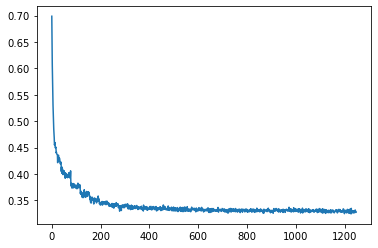

In [33]:
# изменение значения потери в процессе обучения
plt.plot(hist)

In [34]:
# 200 % 100

## тест

In [35]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [36]:
from torchtext.data import Iterator

test_iterator = Iterator(
    test_ds, 
    batch_size = 4096, 
    device=device,
    sort=False, 
    shuffle=False,
)

/usr/lib/python3.9/site-packages/torchtext/data/iterator.py:48: UserWarning: Iterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [42]:
label = []
score = []

with torch.no_grad():
    for batch in test_iterator:
        y_pred = model(batch.text) # вычисляем значения регресии
        y = batch.label
        label.append( y.cpu().detach().numpy() )
        score.append( y_pred.cpu().detach().numpy() )

/usr/lib/python3.9/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [43]:
label = np.hstack(label)
score = np.vstack(score)

In [44]:
y_pred = np.argmax( score ,axis=1)

In [45]:
accuracy_score(label, y_pred)

0.8993975018368846

In [46]:
print(classification_report(label, y_pred) )

              precision    recall  f1-score   support

           0       0.89      0.90      0.90     33477
           1       0.91      0.89      0.90     34573

    accuracy                           0.90     68050
   macro avg       0.90      0.90      0.90     68050
weighted avg       0.90      0.90      0.90     68050

